In [1]:
import pandas as pd
import os
from intervaltree import IntervalTree

In [3]:
def asari_to_trees(ft, mz_err=5, rtime=5):
    mz_tree, rt_tree = IntervalTree(), IntervalTree()
    for id, mz, rtime in zip(ft['id_number'], ft['mz'], ft['rtime']):
        mz_tree.addi(mz - (mz/1e6 * mz_err), mz + (mz/1e6 * mz_err), id)
        rt_tree.addi(rtime-rtime, rtime+rtime, id)
    return mz_tree, rt_tree

def metaboanalyst_to_trees(r_ft, mz_err=5, rtime=5):
    mz_tree, rt_tree = IntervalTree(), IntervalTree()
    for feature in r_ft['Sample'][1:]:
        mz, rtime = [float(x) for x in feature.split('__')]
        mz_tree.addi(mz - (mz/1e6 * mz_err), mz + (mz/1e6 * mz_err), feature)
        rt_tree.addi(rtime-rtime, rtime+rtime, feature)
    return mz_tree, rt_tree

def compare_R_to_asari(r_ft, asari_mz_tree, asari_rt_tree):
    total, matched = 0, 0
    for feature in r_ft['Sample'][1:]:
        mz, rtime = [float(x) for x in feature.split('__')]
        rt_matches = [x.data for x in asari_rt_tree.at(rtime)]
        mz_matches = [x.data for x in asari_mz_tree.at(mz)]
        feature_matched = False
        total += 1
        for match in rt_matches:
            if match in mz_matches:
                feature_matched = True
        if feature_matched:
            matched += 1
    return total, matched

def compare_asari_to_R(a_ft, r_mz_tree, r_rt_tree):
    total, matched = 0, 0
    for _, mz, rtime in zip(a_ft['id_number'], a_ft['mz'], a_ft['rtime']):
        rt_matches = [x.data for x in r_rt_tree.at(rtime)]
        mz_matches = [x.data for x in r_mz_tree.at(mz)]
        feature_matched = False
        total += 1
        for match in rt_matches:
            if match in mz_matches:
                feature_matched = True
        if feature_matched:
            matched += 1
    return total, matched

In [4]:

def search_trees(reference_db, mz_tree, rt_tree):
    matches = {}
    for name, mz, rtime in zip(reference_db["Metabolite"], reference_db["m/z"], reference_db["Retention time (min)"]):
        matches[name] = set()
        rtime = rtime * 60
        mz_matches = [x.data for x in mz_tree.at(mz)]
        rt_matches = [x.data for x in rt_tree.at(rtime)]
        for mz_match in mz_matches:
            if mz_match in rt_matches:
                matches[name].add(mz_match)
    matched = 0
    for name, features in matches.items():
        if features:
            matched += 1
    return len(matches), matched, set([x for x, v in matches.items() if v])




In [5]:
checkmate_annots = pd.read_excel("./CheckMate_annots.xlsx")
checkmate_orbi_asari_dir = "/Users/mitchjo/Analyses/checkmate_orbi_subset/"
for dir, _, files in os.walk(checkmate_orbi_asari_dir):
    for f in files:
        if "preferred_Feature_table.tsv" in f:
            checkmate_orbi_asari_pref = pd.read_csv(os.path.join(dir, f), sep="\t")

checkmate_orbi_metaboanalyst = pd.read_csv("./Checkmate_Orbi_results.csv")
asari_mz_tree, asari_rt_tree = asari_to_trees(checkmate_orbi_asari_pref)
r_mz_tree, r_rt_tree = metaboanalyst_to_trees(checkmate_orbi_metaboanalyst)
total, matched = compare_R_to_asari(checkmate_orbi_metaboanalyst, asari_mz_tree, asari_rt_tree)
print("Total Metaboanalyst: ", total, " Matched to Asari: ", matched)
total, matched = compare_asari_to_R(checkmate_orbi_asari_pref, asari_mz_tree, asari_rt_tree)
print("Total Asari: ", total, " Matched to Metaboanalyst: ", matched)
a_total, asari_found_pref, asari_found_set_pref = search_trees(checkmate_annots, asari_mz_tree, asari_rt_tree)
r_total, r_found, r_found_set = search_trees(checkmate_annots, r_mz_tree, r_rt_tree)
all_standards = checkmate_annots["Metabolite"]

print("Total Standards: ", a_total, " Asari Found: ", asari_found_pref)
print("Total Standards: ", r_total, " Metaboanalyst Found: ", r_found)



Total Metaboanalyst:  3902  Matched to Asari:  2553
Total Asari:  8907  Matched to Metaboanalyst:  8907
Total Standards:  201  Asari Found:  164
Total Standards:  201  Metaboanalyst Found:  167


In [9]:
print("Shared: ", len(r_found_set.intersection(asari_found_set_pref)))
print("R only:", len([x for x in r_found_set if x not in asari_found_set_pref]))
print("Asari only:", len([x for x in asari_found_set_pref if x not in r_found_set]))

with open("found_by_MetaboAnalystR.csv", 'w+') as out_fh:
    print("Features found by MetaboAnalystR", file=out_fh)
    for x in r_found_set:
        print(x, file=out_fh)

with open("found_by_asari_preferred.csv", 'w+') as out_fh:
    print("Features found by pcpfm preferred", file=out_fh)
    for x in asari_found_set_pref:
        print(x, file=out_fh)

with open("found_by_both_preferred.csv", 'w+') as out_fh:
    print("Found by both,(preferred)", file=out_fh)
    for x in r_found_set.intersection(asari_found_set_pref):
        print(x, file=out_fh)

with open("found_by_MetaboAnalystR_only_preferred.csv", 'w+') as out_fh:
    print("Found by MetaboAnalystR only, (preferred)", file=out_fh)
    for x in [x for x in r_found_set if x not in asari_found_set_pref]:
        print(x, file=out_fh)

with open("found_by_pcpfm_only_pref.csv", 'w+') as out_fh:
    print("Found by pcpfm only (pref)" , file=out_fh)
    for x in [x for x in asari_found_set_pref if x not in r_found_set]:
        print(x, file=out_fh)

#copy numbers to the excel

Shared:  143
R only: 24
Asari only: 21


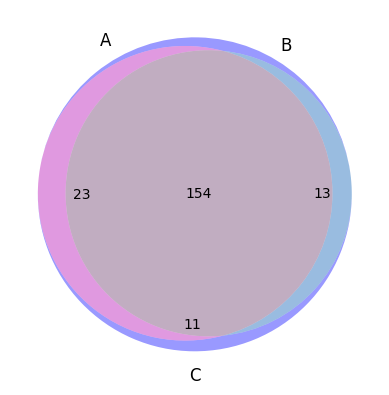

In [35]:
import matplotlib.pyplot as plt



A = asari_found_set_pref
B = r_found_set
C = set([x for x in all_standards])

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()

In [10]:
checkmate_annots = pd.read_excel("./CheckMate_annots.xlsx")
checkmate_orbi_asari_dir = "/Users/mitchjo/Analyses/checkmate_orbi_subset/"
for dir, _, files in os.walk(checkmate_orbi_asari_dir):
    for f in files:
        if "full_Feature_table.tsv" in f:
            checkmate_orbi_asari_full = pd.read_csv(os.path.join(dir, f), sep="\t")
checkmate_orbi_metaboanalyst = pd.read_csv("./Checkmate_Orbi_results.csv")
asari_mz_tree_full, asari_rt_tree_full = asari_to_trees(checkmate_orbi_asari_full)
r_mz_tree, r_rt_tree = metaboanalyst_to_trees(checkmate_orbi_metaboanalyst)
total, matched = compare_R_to_asari(checkmate_orbi_metaboanalyst, asari_mz_tree_full, asari_rt_tree_full)
print("Total Metaboanalyst: ", total, " Matched to Asari: ", matched)
total, matched = compare_asari_to_R(checkmate_orbi_asari_full, asari_mz_tree_full, asari_rt_tree_full)
print("Total Asari: ", total, " Matched to Metaboanalyst: ", matched)
a_total_full, asari_found_full, asari_found_set_full = search_trees(checkmate_annots, asari_mz_tree_full, asari_rt_tree_full)
r_total, r_found, r_found_set = search_trees(checkmate_annots, r_mz_tree, r_rt_tree)
all_standards = checkmate_annots["Metabolite"]

print("Total Standards: ", a_total_full, " Asari Found: ", asari_found_full)
print("Total Standards: ", r_total, " Metaboanalyst Found: ", r_found)

Total Metaboanalyst:  3902  Matched to Asari:  3455
Total Asari:  15992  Matched to Metaboanalyst:  15992
Total Standards:  201  Asari Found:  194
Total Standards:  201  Metaboanalyst Found:  167


In [37]:
print("Shared: ", len(r_found_set.intersection(asari_found_set_full)))
print("R only:", len([x for x in r_found_set if x not in asari_found_set_full]))
print("Asari only:", len([x for x in asari_found_set_full if x not in r_found_set]))

with open("found_by_asari_full.csv", 'w+') as out_fh:
    print("Features found by pcpfm full", file=out_fh)
    for x in asari_found_set_full:
        print(x, file=out_fh)

with open("found_by_both_full.csv", 'w+') as out_fh:
    print("Found by both,(full)", file=out_fh)
    for x in r_found_set.intersection(asari_found_set_full):
        print(x, file=out_fh)

with open("found_by_MetaboAnalystR_only_full.csv", 'w+') as out_fh:
    print("Found by MetaboAnalystR only, (preferred)", file=out_fh)
    for x in [x for x in r_found_set if x not in asari_found_set_full]:
        print(x, file=out_fh)

with open("found_by_pcpfm_only_pref.csv", 'w+') as out_fh:
    print("Found by pcpfm only (full)" , file=out_fh)
    for x in [x for x in asari_found_set_full if x not in r_found_set]:
        print(x, file=out_fh)

# copy numbers to excel

Shared:  167
R only: 0
Asari only: 31


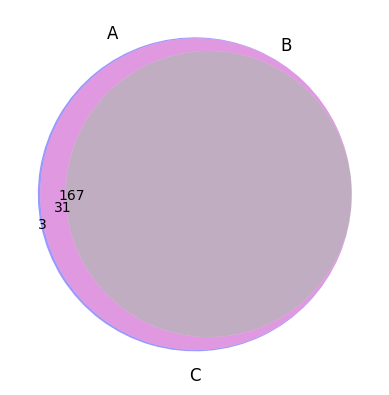

In [38]:
import matplotlib.pyplot as plt



A = asari_found_set_full
B = r_found_set
C = set([x for x in all_standards])

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()